In [34]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ms_deisotope import deconvolute_peaks, averagine, scoring
from ms_deisotope.deconvolution import peak_retention_strategy
import json
from os.path import expanduser


In [98]:
experiment_base_dir = '/media/big-ssd/experiments'
experiment_name = 'P3856'
precursor_definition_method = 'pasef'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
EXPERIMENT_DIR = "{}/{}".format(experiment_base_dir, experiment_name)

In [112]:
# select a precursor cuboid id to visualise
# FEATURES_DIR = "{}/features-{}".format(EXPERIMENT_DIR, precursor_definition_method)
# FEATURES_DEDUP_FILE = '{}/exp-{}-run-{}-features-{}-dedup.pkl'.format(FEATURES_DIR, experiment_name, run_name, precursor_definition_method)
# d = pd.read_pickle(FEATURES_DEDUP_FILE)
# features_df = d['features_df']
# precursor_cuboid_id = features_df.sample(n=1).iloc[0].precursor_cuboid_id
# precursor_cuboid_id

# some good precursors for analysis
# precursor_cuboid_id = 23911
precursor_cuboid_id = 18601

In [113]:
VIS_FILE = '{}/feature-detection-visualisation-{}.pkl'.format(expanduser("~"), precursor_cuboid_id)

In [114]:
# load the visualisation file for this precursor cuboid
vis_d = pd.read_pickle(VIS_FILE)
vis_d.keys()

dict_keys(['precursor_cuboid_d', 'wide_ms1_points_df', 'peaks_after_intensity_descent', 'deconvolution_features_df', 'features_df'])

In [115]:
features_df = vis_d['features_df']

In [116]:
fragment_ions_df = pd.DataFrame(json.loads(features_df[(features_df.precursor_cuboid_id == precursor_cuboid_id)].iloc[0].fragment_ions_l))

In [117]:
fragment_ions_df

,singly_protonated_mass,neutral_mass,intensity
0,209.1055,208.0982,179.0
1,260.1973,259.1901,167.0
2,300.1194,299.1121,414.0
3,326.1542,325.1469,186.0
4,337.1633,336.1560,345.0
...,...,...,...
98,961.5345,960.5272,154.0
99,1119.5584,1118.5511,999.0
100,1120.5690,1119.5617,397.0
101,1165.4643,1164.4570,190.0


In [118]:
# create the bins for mass defect windows in Da space
def generate_mass_defect_windows(mass_defect_window_da_min, mass_defect_window_da_max):
    bin_edges_l = []
    for nominal_mass in range(mass_defect_window_da_min, mass_defect_window_da_max):
        mass_centre = nominal_mass * 1.00048  # from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3184890/
        width = 0.19 + (0.0001 * nominal_mass)
        lower_mass = mass_centre - (width / 2)
        upper_mass = mass_centre + (width / 2)
        bin_edges_l.append((lower_mass, upper_mass))
    return bin_edges_l

In [119]:
# generate the mass defect windows
bins_l = generate_mass_defect_windows(int(fragment_ions_df.neutral_mass.min()), int(fragment_ions_df.neutral_mass.max()))

In [120]:
bins = pd.IntervalIndex.from_tuples(bins_l)
fragment_ions_df['bin'] = pd.cut(fragment_ions_df.neutral_mass, bins)
fragment_ions_df['normalised_intensity'] = fragment_ions_df.intensity / fragment_ions_df.intensity.max()

In [121]:
filtered_fragment_ions_df = fragment_ions_df.dropna(subset = ['bin']).copy()
filtered_fragment_ions_df.drop('bin', axis=1, inplace=True)
filtered_fragment_ions_df['normalised_intensity'] = filtered_fragment_ions_df.intensity / filtered_fragment_ions_df.intensity.max()


In [122]:
removed = len(fragment_ions_df) - len(filtered_fragment_ions_df)
print('removed {} points ({}%)'.format(removed, round(removed/len(fragment_ions_df)*100,1)))

removed 24 points (23.3%)


In [123]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

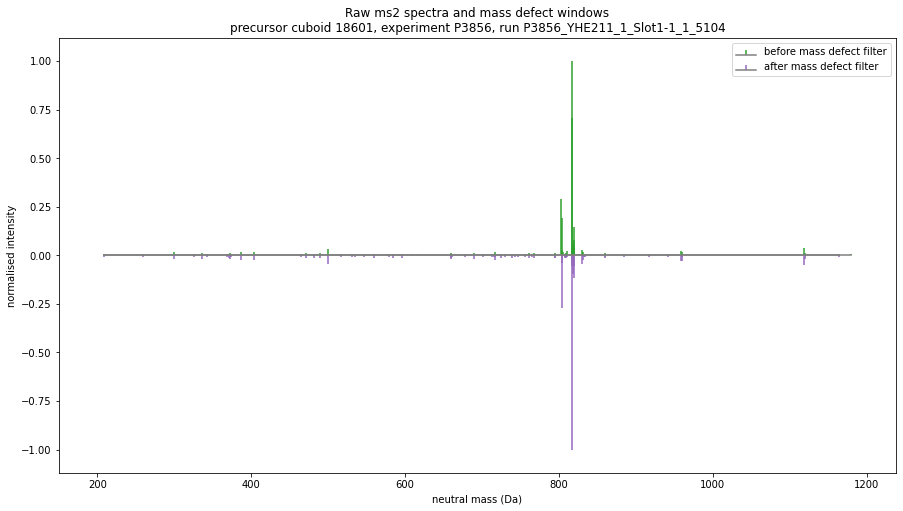

In [124]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# plot the raw data
markerline, stemlines, baseline = ax.stem(fragment_ions_df.neutral_mass, fragment_ions_df.normalised_intensity, markerfmt=" ", use_line_collection=True, label='before mass defect filter')
plt.setp(markerline, 'color', 'tab:green')
plt.setp(stemlines, 'color', 'tab:green')
plt.setp(baseline, 'color', 'tab:gray')

# plot the filtered data
markerline, stemlines, baseline = ax.stem(filtered_fragment_ions_df.neutral_mass, -filtered_fragment_ions_df.normalised_intensity, markerfmt=" ", use_line_collection=True, label='after mass defect filter')
plt.setp(markerline, 'color', 'tab:purple')
plt.setp(stemlines, 'color', 'tab:purple')
plt.setp(baseline, 'color', 'tab:gray')

plt.xlabel('neutral mass (Da)')
plt.ylabel('normalised intensity')
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.legend(loc='best')
plt.title('Raw ms2 spectra and mass defect windows\nprecursor cuboid {}, experiment {}, run {}'.format(precursor_cuboid_id, experiment_name, run_name))
plt.show()